# 1. Labraries Loading

In [1]:
import pandas as pd
import numpy as np
from datetime import timezone, datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm

# 2. Dataset opening

In [96]:
measurementsDf = pd.read_csv('../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [9]:
"""dayDf = pd.DataFrame(columns = ["day"])
monthDf = pd.DataFrame(columns = ["month"])
hourDf = pd.DataFrame(columns = ["hour"])"""

# 3. Time DataFrame Creation

Therefore, only the months, days and hours of the measurements were extracted in numerical format because these algorithms work better with discrete data.

In [10]:
#Function responsable for extracting the months, days and hours of the measurements.
def dayMonthTimeDataFrameCreator():
    for i in range(len(measurementsDf['time'])):
        timeContainer  = measurementsDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        monthDf.loc[i] = timeContainer.month
        dayDf.loc[i] = timeContainer.day
        hourDf.loc[i] = timeContainer.time().hour

In [11]:
%%time

dayMonthTimeDataFrameCreator()

CPU times: total: 16min 50s
Wall time: 17min 3s


Bellow the months, days and hours dataframes are joined into one dataframe

In [60]:
timeDf = dayDf.join(monthDf)
timeDf = timeDf.join(hourDf)

In [61]:
timeDf

,day,month,hour
0,14,7,14
1,14,7,15
2,14,7,16
3,14,7,17
4,14,7,18
...,...,...,...
115629,31,12,19
115630,31,12,20
115631,31,12,21
115632,31,12,22


Its always important to check if there is any null values on the DF

In [14]:
timeDf.isnull().sum()

day      0
month    0
hour     0
dtype: int64

In [62]:
measurementsDf = timeDf.join(measurementsDf)
measurementsDf

,day,month,hour,time,T,Rn,H,P,CO2,sensor_id
0,14,7,14,2020-07-14T14:00:00.000Z,31.300000,NaN,44.475000,NaN,567.750000,D0001
1,14,7,15,2020-07-14T15:00:00.000Z,31.333333,NaN,45.505556,NaN,636.361111,D0001
2,14,7,16,2020-07-14T16:00:00.000Z,31.451429,NaN,47.145714,NaN,734.000000,D0001
3,14,7,17,2020-07-14T17:00:00.000Z,31.161765,NaN,36.000000,NaN,461.529412,D0001
4,14,7,18,2020-07-14T18:00:00.000Z,31.008333,NaN,28.436111,NaN,400.000000,D0001
...,...,...,...,...,...,...,...,...,...,...
115629,31,12,19,2021-12-31T19:00:00.000Z,NaN,616.640000,NaN,102.653100,97.200000,D009
115630,31,12,20,2021-12-31T20:00:00.000Z,NaN,541.380000,NaN,102.273400,97.800000,D009
115631,31,12,21,2021-12-31T21:00:00.000Z,NaN,544.167273,NaN,102.199727,97.181818,D009
115632,31,12,22,2021-12-31T22:00:00.000Z,NaN,590.666000,NaN,102.140000,98.100000,D009


In [100]:
measurementsDf = measurementsDf.drop(['time'],axis = 1)# We can get rid of the normal time DF
sensors_id_Df = measurementsDf.pop('sensor_id')# We save the sensors id for a later use to restore the "original" DF state
sensors_id_Df = sensors_id_Df.to_frame()

# 3. time DataFrame creation

In [64]:
measurementsDf.head(20)

,day,month,hour,T,Rn,H,P,CO2
0,14,7,14,31.300000,NaN,44.475000,NaN,567.750000
1,14,7,15,31.333333,NaN,45.505556,NaN,636.361111
2,14,7,16,31.451429,NaN,47.145714,NaN,734.000000
3,14,7,17,31.161765,NaN,36.000000,NaN,461.529412
4,14,7,18,31.008333,NaN,28.436111,NaN,400.000000
5,14,7,19,30.647222,NaN,29.133333,NaN,400.000000
6,14,7,20,29.891429,NaN,28.597143,NaN,400.000000
7,14,7,21,29.118919,NaN,29.162162,NaN,400.000000
8,14,7,22,28.200000,NaN,31.611111,NaN,400.000000
9,14,7,23,28.280556,NaN,32.111111,NaN,441.916667


In [101]:
discrete_features = [col for col in measurementsDf.columns if measurementsDf[col].dtype != object]

In [102]:
discrete_features

['T', 'Rn', 'H', 'P', 'CO2']

In [103]:
print(measurementsDf.shape)

(115634, 5)


# 4. Data Pre-processing

In [22]:
# Its important to check for the null values

measurementsDf.isnull().sum()

day          0
month        0
hour         0
T        36531
Rn        3095
H        36531
P        29018
CO2       2216
dtype: int64

In [51]:
# Null values visualization
#measurementsDf = measurementsDf.drop(['time'],axis = 1)
measurementsDf[measurementsDf['T'].isnull()]

,T,Rn,H,P,CO2
1225,NaN,NaN,NaN,101.689026,183.743590
1226,NaN,NaN,NaN,101.680974,181.868421
1227,NaN,NaN,NaN,101.692096,181.019231
1228,NaN,NaN,NaN,101.684137,182.490196
1229,NaN,NaN,NaN,101.722314,182.666667
...,...,...,...,...,...
115629,NaN,616.640000,NaN,102.653100,97.200000
115630,NaN,541.380000,NaN,102.273400,97.800000
115631,NaN,544.167273,NaN,102.199727,97.181818
115632,NaN,590.666000,NaN,102.140000,98.100000


## 4.1 Data inputation using mean, median and most frequent from sklearn input librabry

### Mean inputation

In [24]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

measurementsDf['T'] =  imputer.fit_transform(measurementsDf[["T"]]).ravel()
measurementsDf['Rn'] =  imputer.fit_transform(measurementsDf[["Rn"]]).ravel()
measurementsDf['H'] =  imputer.fit_transform(measurementsDf[["H"]]).ravel()
measurementsDf['P'] =  imputer.fit_transform(measurementsDf[["P"]]).ravel()
measurementsDf['CO2'] =  imputer.fit_transform(measurementsDf[["CO2"]]).ravel()

measurementsDf.head(15)

,day,month,hour,T,Rn,H,P,CO2
0,14,7,14,31.300000,653.819844,44.475000,101.844916,567.750000
1,14,7,15,31.333333,653.819844,45.505556,101.844916,636.361111
2,14,7,16,31.451429,653.819844,47.145714,101.844916,734.000000
3,14,7,17,31.161765,653.819844,36.000000,101.844916,461.529412
4,14,7,18,31.008333,653.819844,28.436111,101.844916,400.000000
5,14,7,19,30.647222,653.819844,29.133333,101.844916,400.000000
6,14,7,20,29.891429,653.819844,28.597143,101.844916,400.000000
7,14,7,21,29.118919,653.819844,29.162162,101.844916,400.000000
8,14,7,22,28.200000,653.819844,31.611111,101.844916,400.000000
9,14,7,23,28.280556,653.819844,32.111111,101.844916,441.916667


In [26]:
#measurementsDf =  measurementsDf.drop(['time'],axis =1)
#measurementsDf = timeDf.join(measurementsDf)
measurementsDf

,day,month,hour,T,Rn,H,P,CO2
0,14,7,14,31.300000,653.819844,44.475000,101.844916,567.750000
1,14,7,15,31.333333,653.819844,45.505556,101.844916,636.361111
2,14,7,16,31.451429,653.819844,47.145714,101.844916,734.000000
3,14,7,17,31.161765,653.819844,36.000000,101.844916,461.529412
4,14,7,18,31.008333,653.819844,28.436111,101.844916,400.000000
...,...,...,...,...,...,...,...,...
115629,31,12,19,27.346670,616.640000,44.549572,102.653100,97.200000
115630,31,12,20,27.346670,541.380000,44.549572,102.273400,97.800000
115631,31,12,21,27.346670,544.167273,44.549572,102.199727,97.181818
115632,31,12,22,27.346670,590.666000,44.549572,102.140000,98.100000


Saving the mean version to a csv file

In [27]:
measurementsDf.to_csv('measurementsImputedByMean.csv',index=False)

### Median inputation

In [30]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

measurementsDf['T'] =  imputer.fit_transform(measurementsDf[["T"]]).ravel()
measurementsDf['Rn'] =  imputer.fit_transform(measurementsDf[["Rn"]]).ravel()
measurementsDf['H'] =  imputer.fit_transform(measurementsDf[["H"]]).ravel()
measurementsDf['P'] =  imputer.fit_transform(measurementsDf[["P"]]).ravel()
measurementsDf['CO2'] =  imputer.fit_transform(measurementsDf[["CO2"]]).ravel()

measurementsDf.head(15)

,T,Rn,H,P,CO2
0,31.300000,322.661818,44.475000,101.695636,567.750000
1,31.333333,322.661818,45.505556,101.695636,636.361111
2,31.451429,322.661818,47.145714,101.695636,734.000000
3,31.161765,322.661818,36.000000,101.695636,461.529412
4,31.008333,322.661818,28.436111,101.695636,400.000000
5,30.647222,322.661818,29.133333,101.695636,400.000000
6,29.891429,322.661818,28.597143,101.695636,400.000000
7,29.118919,322.661818,29.162162,101.695636,400.000000
8,28.200000,322.661818,31.611111,101.695636,400.000000
9,28.280556,322.661818,32.111111,101.695636,441.916667


In [32]:
#measurementsDf =  measurementsDf.drop(['time'],axis =1)
measurementsDf = timeDf.join(measurementsDf)
measurementsDf

,day,month,hour,T,Rn,H,P,CO2
0,14,7,14,31.300000,322.661818,44.475000,101.695636,567.750000
1,14,7,15,31.333333,322.661818,45.505556,101.695636,636.361111
2,14,7,16,31.451429,322.661818,47.145714,101.695636,734.000000
3,14,7,17,31.161765,322.661818,36.000000,101.695636,461.529412
4,14,7,18,31.008333,322.661818,28.436111,101.695636,400.000000
...,...,...,...,...,...,...,...,...
115629,31,12,19,27.505455,616.640000,38.800000,102.653100,97.200000
115630,31,12,20,27.505455,541.380000,38.800000,102.273400,97.800000
115631,31,12,21,27.505455,544.167273,38.800000,102.199727,97.181818
115632,31,12,22,27.505455,590.666000,38.800000,102.140000,98.100000


Saving the median version to a csv file

In [33]:
measurementsDf.to_csv('measurementsImputedMedian.csv',index=False)

### Iterative imputation

In [85]:
iterative_imputater = IterativeImputer(random_state=42)
iterative_imputater = iterative_imputater.fit_transform(measurementsDf[discrete_features])
imputedDf = pd.DataFrame(iterative_imputater, columns=discrete_features)

In [87]:
imputedDf

,T,Rn,H,P,CO2
0,31.300000,486.532243,44.475000,101.754718,567.750000
1,31.333333,456.971399,45.505556,101.765173,636.361111
2,31.451429,406.606073,47.145714,101.777827,734.000000
3,31.161765,806.368902,36.000000,101.707682,461.529412
4,31.008333,1098.201559,28.436111,101.670283,400.000000
...,...,...,...,...,...
115629,26.603238,616.640000,42.512221,102.653100,97.200000
115630,27.040535,541.380000,42.655605,102.273400,97.800000
115631,27.145019,544.167273,42.435892,102.199727,97.181818
115632,27.277025,590.666000,41.639520,102.140000,98.100000


In [89]:
imputedDf = imputedDf.join(sensors_id_Df)
imputedDf =  timeDf.join(imputedDf)

In [90]:
imputedDf

,day,month,hour,T,Rn,H,P,CO2,sensor_id
0,14,7,14,31.300000,486.532243,44.475000,101.754718,567.750000,D0001
1,14,7,15,31.333333,456.971399,45.505556,101.765173,636.361111,D0001
2,14,7,16,31.451429,406.606073,47.145714,101.777827,734.000000,D0001
3,14,7,17,31.161765,806.368902,36.000000,101.707682,461.529412,D0001
4,14,7,18,31.008333,1098.201559,28.436111,101.670283,400.000000,D0001
...,...,...,...,...,...,...,...,...,...
115629,31,12,19,26.603238,616.640000,42.512221,102.653100,97.200000,D009
115630,31,12,20,27.040535,541.380000,42.655605,102.273400,97.800000,D009
115631,31,12,21,27.145019,544.167273,42.435892,102.199727,97.181818,D009
115632,31,12,22,27.277025,590.666000,41.639520,102.140000,98.100000,D009


In [91]:
imputedDf.isna().sum()

day          0
month        0
hour         0
T            0
Rn           0
H            0
P            0
CO2          0
sensor_id    0
dtype: int64

The date related columns where converted to float data type so we need to parse it back to integer data type

In [92]:
imputedDf['day'] = (imputedDf['day']).astype(int)
imputedDf['month'] = (imputedDf['month']).astype(int)
imputedDf['hour'] = (imputedDf['hour']).astype(int)

In [93]:
imputedDf

,day,month,hour,T,Rn,H,P,CO2,sensor_id
0,14,7,14,31.300000,486.532243,44.475000,101.754718,567.750000,D0001
1,14,7,15,31.333333,456.971399,45.505556,101.765173,636.361111,D0001
2,14,7,16,31.451429,406.606073,47.145714,101.777827,734.000000,D0001
3,14,7,17,31.161765,806.368902,36.000000,101.707682,461.529412,D0001
4,14,7,18,31.008333,1098.201559,28.436111,101.670283,400.000000,D0001
...,...,...,...,...,...,...,...,...,...
115629,31,12,19,26.603238,616.640000,42.512221,102.653100,97.200000,D009
115630,31,12,20,27.040535,541.380000,42.655605,102.273400,97.800000,D009
115631,31,12,21,27.145019,544.167273,42.435892,102.199727,97.181818,D009
115632,31,12,22,27.277025,590.666000,41.639520,102.140000,98.100000,D009


Finally we save the data to the csv

In [95]:
imputedDf.to_csv('measurementsImputedByIterativeImputator.csv',index=False)

### KNN imputation

Bellow is the current state of the dataframe that it is going to be processed:

In [104]:
measurementsDf

,T,Rn,H,P,CO2
0,31.300000,NaN,44.475000,NaN,567.750000
1,31.333333,NaN,45.505556,NaN,636.361111
2,31.451429,NaN,47.145714,NaN,734.000000
3,31.161765,NaN,36.000000,NaN,461.529412
4,31.008333,NaN,28.436111,NaN,400.000000
...,...,...,...,...,...
115629,NaN,616.640000,NaN,102.653100,97.200000
115630,NaN,541.380000,NaN,102.273400,97.800000
115631,NaN,544.167273,NaN,102.199727,97.181818
115632,NaN,590.666000,NaN,102.140000,98.100000


For the KNN imputation work as planned, we must first normalize the data using one of the scikit learn libraries, MinMaxScaler, which will transform the data to values beetween 0 and 1 

In [105]:
scaler = MinMaxScaler()
scaledDf = pd.DataFrame(scaler.fit_transform(measurementsDf), columns = measurementsDf.columns)

We can see bellow that the featueres have values between 0 and 1

In [106]:
scaledDf.head()

,T,Rn,H,P,CO2
0,0.733021,NaN,0.468158,NaN,0.047865
1,0.733802,NaN,0.479006,NaN,0.053650
2,0.736567,NaN,0.496271,NaN,0.061881
3,0.729784,NaN,0.378947,NaN,0.038910
4,0.726190,NaN,0.299327,NaN,0.033723


Now everything is ready to realize the imputation

In [107]:
%%time

imputer = KNNImputer(n_neighbors=5)
scaledDf = pd.DataFrame(imputer.fit_transform(scaledDf),columns = scaledDf.columns)

CPU times: total: 12min 12s
Wall time: 10min 1s


In [118]:
backupDf = scaledDf
scaledDf

,T,Rn,H,P,CO2
0,0.733021,0.270933,0.468158,0.967662,0.047865
1,0.733802,0.159120,0.479006,0.968301,0.053650
2,0.736567,0.000027,0.496271,0.967408,0.061881
3,0.729784,0.282132,0.378947,0.967054,0.038910
4,0.726190,0.429000,0.299327,0.967675,0.033723
...,...,...,...,...,...
115629,0.697721,0.166826,0.527962,0.978021,0.008195
115630,0.701444,0.146465,0.505761,0.974404,0.008245
115631,0.710286,0.147219,0.566813,0.973702,0.008193
115632,0.691129,0.159799,0.464185,0.973133,0.008270


In [109]:
scaledDf.isna().any()

T      False
Rn     False
H      False
P      False
CO2    False
dtype: bool

After the imputation is done, the dataframe values are reversed to the original state

In [119]:
reverseDf = scaler.inverse_transform(scaledDf)

In [121]:
reverseDf = pd.DataFrame(reverseDf)

In [122]:
reverseDf

,0,1,2,3,4
0,31.300000,1001.448424,44.475000,101.565847,567.750000
1,31.333333,588.154974,45.505556,101.632854,636.361111
2,31.451429,0.100000,47.145714,101.539128,734.000000
3,31.161765,1042.843803,36.000000,101.501998,461.529412
4,31.008333,1585.713833,28.436111,101.567130,400.000000
...,...,...,...,...,...
115629,29.792673,616.640000,50.156364,102.653100,97.200000
115630,29.951673,541.380000,48.047273,102.273400,97.800000
115631,30.329218,544.167273,53.847273,102.199727,97.181818
115632,29.511200,590.666000,44.097576,102.140000,98.100000


After reversing the DataFrame, the columns names are indexed, so we need to change back the names to the original form

In [123]:
reverseDf = reverseDf.rename(columns = {
    0 : 'T',
    1 : 'Rn',
    2 : 'H',
    3 : 'P',
    4 : 'CO2',
})

In [124]:
reverseDf = t

,T,Rn,H,P,CO2
0,31.300000,1001.448424,44.475000,101.565847,567.750000
1,31.333333,588.154974,45.505556,101.632854,636.361111
2,31.451429,0.100000,47.145714,101.539128,734.000000
3,31.161765,1042.843803,36.000000,101.501998,461.529412
4,31.008333,1585.713833,28.436111,101.567130,400.000000
...,...,...,...,...,...
115629,29.792673,616.640000,50.156364,102.653100,97.200000
115630,29.951673,541.380000,48.047273,102.273400,97.800000
115631,30.329218,544.167273,53.847273,102.199727,97.181818
115632,29.511200,590.666000,44.097576,102.140000,98.100000


The date related columns where converted to float data type so we need to parse it back to integer data type

In [114]:
reverseDf['day'] = (reverseDf['day']).astype(int)
reverseDf['month'] = (reverseDf['month']).astype(int)
reverseDf['hour'] = (reverseDf['hour']).astype(int)

In [115]:
reverseDf.head()

,day,month,hour,T,Rn
0,31,1001,44,101.565847,567.750000
1,31,588,45,101.632854,636.361111
2,31,0,47,101.539128,734.000000
3,31,1042,36,101.501998,461.529412
4,31,1585,28,101.567130,400.000000


In [125]:
reverseDf = timeDf.join(reverseDf)

The dropped non-numerical columns are put back

In [126]:
reverseDf = reverseDf.join(sensors_id_Df)
reverseDf

,day,month,hour,T,Rn,H,P,CO2,sensor_id
0,14,7,14,31.300000,1001.448424,44.475000,101.565847,567.750000,D0001
1,14,7,15,31.333333,588.154974,45.505556,101.632854,636.361111,D0001
2,14,7,16,31.451429,0.100000,47.145714,101.539128,734.000000,D0001
3,14,7,17,31.161765,1042.843803,36.000000,101.501998,461.529412,D0001
4,14,7,18,31.008333,1585.713833,28.436111,101.567130,400.000000,D0001
...,...,...,...,...,...,...,...,...,...
115629,31,12,19,29.792673,616.640000,50.156364,102.653100,97.200000,D009
115630,31,12,20,29.951673,541.380000,48.047273,102.273400,97.800000,D009
115631,31,12,21,30.329218,544.167273,53.847273,102.199727,97.181818,D009
115632,31,12,22,29.511200,590.666000,44.097576,102.140000,98.100000,D009


In [127]:
timeDf.isna().sum()

day      0
month    0
hour     0
dtype: int64

Finally we save the data to the csv

In [128]:
reverseDf.to_csv('measurementsImputedByKnn.csv',index=False)

## Loading imputed data

After imputing all null values, we can now open the saved dataset with no empty values.

In [130]:
imputedMeasurementsDf = pd.read_csv('../../../../Data/ProcessedData/KnnImputed/measurementsImputedByKnn.csv')

We will also import the raw dataset to extract the time column, convert it to a datetime frame and concat it to the processed DF for a future use on the model training

In [131]:
measurementsDf = pd.read_csv('../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [132]:
dateTimeDf = pd.DataFrame(measurementsDf['time'])

In [133]:
def iso8601ToDatetime():
    for i in range(len(dateTimeDf['time'])):
        timeContainer  = dateTimeDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        dateTimeDf['time'][i] = timeContainer

In [134]:
%%time

iso8601ToDatetime()

CPU times: total: 10.7 s
Wall time: 10.9 s


In [135]:
df = dateTimeDf.join(imputedMeasurementsDf.drop(['day','month','hour'],axis = 1))

In [136]:
df

,time,T,Rn,H,P,CO2,sensor_id
0,2020-07-14 14:00:00,31.300000,1001.448424,44.475000,101.565847,567.750000,D0001
1,2020-07-14 15:00:00,31.333333,588.154974,45.505556,101.632854,636.361111,D0001
2,2020-07-14 16:00:00,31.451429,0.100000,47.145714,101.539128,734.000000,D0001
3,2020-07-14 17:00:00,31.161765,1042.843803,36.000000,101.501998,461.529412,D0001
4,2020-07-14 18:00:00,31.008333,1585.713833,28.436111,101.567130,400.000000,D0001
...,...,...,...,...,...,...,...
115629,2021-12-31 19:00:00,29.792673,616.640000,50.156364,102.653100,97.200000,D009
115630,2021-12-31 20:00:00,29.951673,541.380000,48.047273,102.273400,97.800000,D009
115631,2021-12-31 21:00:00,30.329218,544.167273,53.847273,102.199727,97.181818,D009
115632,2021-12-31 22:00:00,29.511200,590.666000,44.097576,102.140000,98.100000,D009


In [137]:
type(df['time'][0])

datetime.datetime

### Data cleaning: handling outliers

In [138]:
df.describe()

,T,Rn,H,P,CO2
count,115634.000000,115634.000000,115634.000000,115634.000000,115634.000000
mean,28.453081,654.611010,44.634228,101.765708,97.238103
std,4.555721,1001.896172,15.070180,0.801784,215.936069
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.822317,122.683333,33.400000,101.343500,38.500000
50%,29.462707,327.276629,41.000000,101.605635,66.833333
75%,31.445000,593.150972,53.925455,102.136225,109.500000
max,42.700000,3696.300000,95.000000,104.960000,11861.444444


### Temperature column - normal scale (4ºC to 34ºC)
https://weatherspark.com/y/32022/Average-Weather-in-Lisbon-Portugal-Year-Round 

##### Before removing the outliers

Histogram:


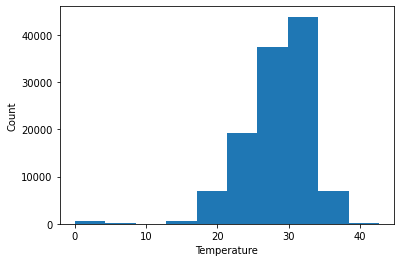

Boxplot:


<AxesSubplot:xlabel='T'>

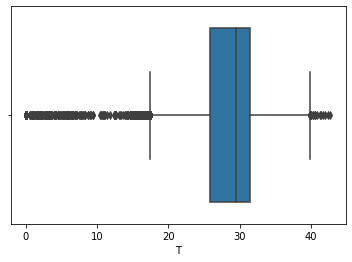

In [139]:
print("Histogram:")
plt.hist(df['T'])
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()

print("Boxplot:")
rng = np.arange(df['T'].min(),df['T'].max(), 0.1)
sns.boxplot(x=df['T'])

In [145]:
#minBoundryDf = df[df['T'] <= 10 ]

In [146]:
"""
print("Histogram:")
plt.hist(minBoundryDf['T'])
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()

print("Boxplot:")
rng = np.arange(minBoundryDf['T'].min(),minBoundryDf['T'].max(), 0.1)
sns.boxplot(x=minBoundryDf['T']) """

'\nprint("Histogram:")\nplt.hist(minBoundryDf[\'T\'])\nplt.xlabel(\'Temperature\')\nplt.ylabel(\'Count\')\nplt.show()\n\nprint("Boxplot:")\nrng = np.arange(minBoundryDf[\'T\'].min(),minBoundryDf[\'T\'].max(), 0.1)\nsns.boxplot(x=minBoundryDf[\'T\'])'

### Radon column (0Bq/m3 to 100Bq/m3 = safe) | (100Bq/m3 to 150Bq/m3 = Alert) | (Above then 150= Warning)
https://www.airthings.com/hs-fs/hubfs/Website/Images/Newsletter/Blog/Blog%20body%20images%20compressed%20-illustration/unsplash/Radon%20level%20chart.jpg?width=920&name=Radon%20level%20chart.jpg

##### Before removing the outliers

Histogram:


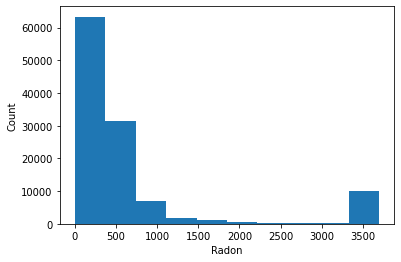

Boxplot:


<AxesSubplot:xlabel='Rn'>

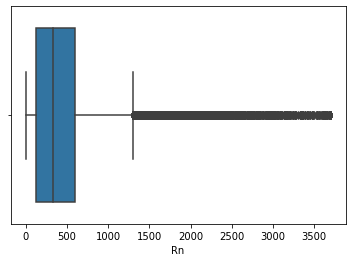

In [142]:
print("Histogram:")
plt.hist(df['Rn'])
plt.xlabel('Radon')
plt.ylabel('Count')
plt.show()

print("Boxplot:")
sns.boxplot(x=df['Rn'])

##### After removing the outliers

In [143]:
"""min_radon_threshold, max_radon_threshold = df['Rn'].quantile([0.001,0.999])
print(min_radon_threshold)
print(max_radon_threshold)"""

0.0
3696.3000000000015


In [200]:
#cleanRadonFrame = df[(df['Rn'] < max_radon_threshold) & (df['Rn'] > min_radon_threshold )]

In [201]:
#cleanRadonFrame

,time,T,Rn,H,P,CO2,sensor_id
0,2020-06-27 10:00:00,3.000000,1184.462167,14.000000,101.819429,90.400000,@0123
1,2020-07-14 14:00:00,31.300000,1052.755715,44.475000,101.690888,567.750000,D0001
2,2020-07-14 15:00:00,31.333333,1067.930542,45.505556,101.636782,636.361111,D0001
3,2020-07-14 16:00:00,31.451429,737.212667,47.145714,102.001417,734.000000,D0001
4,2020-07-14 17:00:00,31.161765,1719.099515,36.000000,101.600718,461.529412,D0001
...,...,...,...,...,...,...,...
117269,2020-06-27 10:00:00,0.828713,1184.462167,11.210526,101.819429,90.400000,undefined
117270,2020-06-27 11:00:00,0.828713,1111.754503,8.500000,101.918567,95.649697,undefined
117271,2020-06-27 12:00:00,0.616014,317.275024,9.000000,101.962261,86.136667,undefined
117272,2020-08-19 13:00:00,30.000000,603.863591,48.000000,100.911807,65.548485,undefined


Histogram:


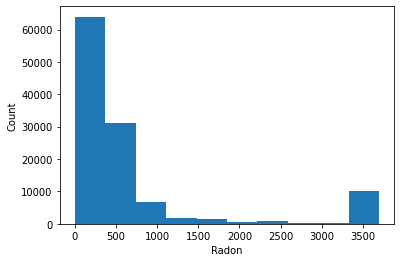

Boxplot:


<AxesSubplot:xlabel='Rn'>

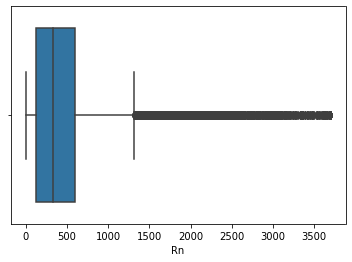

In [202]:
"""print("Histogram:")
plt.hist(cleanRadonFrame['Rn'])
plt.xlabel('Radon')
plt.ylabel('Count')
plt.show()

print("Boxplot:")
sns.boxplot(x=cleanRadonFrame['Rn'])"""

### Humidity column (30% to 60% is healthy level range)
https://www.airthings.com/hs-fs/hubfs/Website/Images/Newsletter/Blog/Blog%20body%20images%20compressed%20-illustration/Humidity%20level%20chart%20(1).jpg?width=3508&name=Humidity%20level%20chart%20(1).jpg

##### Before removing the outliers

Histogram:


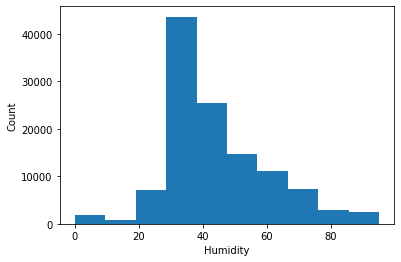

Boxplot:


<AxesSubplot:xlabel='H'>

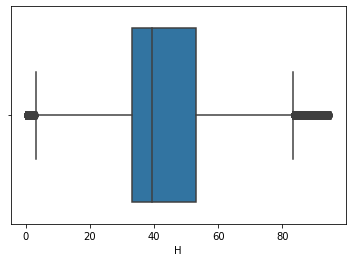

In [148]:
print("Histogram:")
plt.hist(df['H'])
plt.xlabel('Humidity')
plt.ylabel('Count')
plt.show()

print("Boxplot:")
sns.boxplot(x=df['H'])

##### After removing the outliers

### Pressure column (standard pressure = 101.325kPa) https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Atmospheric_Pressure_vs._Altitude.png/300px-Atmospheric_Pressure_vs._Altitude.png  )

Histogram:


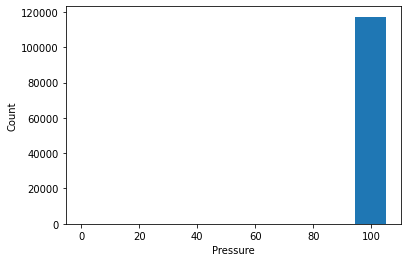

Boxplot:


<AxesSubplot:xlabel='P'>

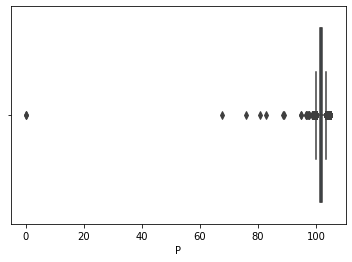

In [149]:
print("Histogram:")

plt.hist(df['P'])
plt.xlabel('Pressure')
plt.ylabel('Count')
plt.show()

print("Boxplot:")
sns.boxplot(x=df['P'])

### Carbon Dioxide column - (0ppm to 2000ppm)  https://www.kane.co.uk/knowledge-centre/what-are-safe-levels-of-co-and-co2-in-rooms 

##### Before removing the outliers

Histogram:


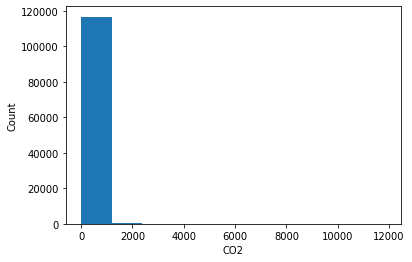

Boxplot:


<AxesSubplot:xlabel='CO2'>

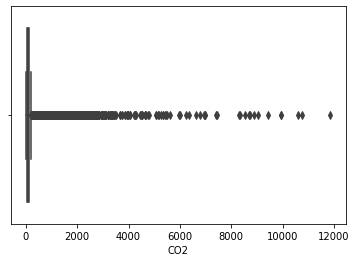

In [151]:
print("Histogram:")

plt.hist(df['CO2'])
plt.xlabel('CO2')
plt.ylabel('Count')
plt.show()

print("Boxplot:")

sns.boxplot(x=df['CO2'])

##### Aftter removing the outliers